In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from env import user_name, password, host
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',None) 
pd.set_option('display.max_rows',None)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

In [2]:
#Acquire

In [3]:
def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user_name}:{password}@{host}/{db_name}'

#Create query to get necessary data
def telco_data():
    '''
    This function reads in the telcoco data from the Codeup db
    and returns a pandas DataFrame with all columns and it was joined with other tables.
    '''
    sql_query = '''
    Select * from customers
    join contract_types on contract_types.contract_type_id = customers.contract_type_id
    join payment_types on payment_types.payment_type_id = customers.payment_type_id
    join internet_service_types on internet_service_types.internet_service_type_id = customers.internet_service_type_id
    '''
    return pd.read_sql(sql_query,get_connection('telco_churn'))

In [4]:
telco_df = telco_data()

In [5]:
telco_df.shape

(7043, 27)

In [6]:
telco_df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type_id,contract_type,payment_type_id,payment_type,internet_service_type_id,internet_service_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,Yes,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No,2,One year,2,Mailed check,1,DSL
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,No,No,No,No,Yes,1,No,2,59.9,542.4,No,1,Month-to-month,2,Mailed check,1,DSL
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,No,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,Yes,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,No,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes,1,Month-to-month,2,Mailed check,2,Fiber optic


In [7]:
telco_df.isna().sum()

customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
internet_service_type_id    0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
contract_type_id            0
paperless_billing           0
payment_type_id             0
monthly_charges             0
total_charges               0
churn                       0
contract_type_id            0
contract_type               0
payment_type_id             0
payment_type                0
internet_service_type_id    0
internet_service_type       0
dtype: int64

In [8]:
#We can see the there are some duplicates columns but threre is no duplicates value
telco_df.duplicated().sum()

0

In [8]:
telco_df.contract_type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64

In [9]:
#We drop the duplicates values if it exists and changing the type in total charges
telco_df = telco_df.drop_duplicates()
telco_df['total_charges'] = telco_df.total_charges.replace(' ', '0').astype(float)

In [10]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

In [11]:
#Replacing no internet service and no phone service with a no so it alittle easier to encoding
telco_df.replace('No internet service', 'No', inplace=True)
telco_df.replace('No phone service', 'No', inplace = True)

In [12]:
#Changing the type of some columns that are object but not all
#Do the same for other columns except contract type, payment type and internet service
#These columns has 3 values in them. 
#For example, it harder to understand one year = 0 and two year = 0, they are the same as month to month 
telco_df["is_male"] = telco_df.gender == "Male"
telco_df['is_male'] = telco_df['is_male'].astype(int)

telco_df["partner"] = telco_df.partner == "Yes"
telco_df['partner'] = (telco_df['partner']).astype(int)

telco_df["dependents"] = telco_df.dependents == "Yes"
telco_df['dependents'] = (telco_df['dependents']).astype(int)

telco_df["phone_service"] = telco_df.phone_service == "Yes"
telco_df['phone_service'] = (telco_df['phone_service']).astype(int)

telco_df["streaming_tv"] = telco_df.streaming_tv == "Yes"
telco_df['streaming_tv'] = (telco_df['streaming_tv']).astype(int)

telco_df["streaming_movies"] = telco_df.streaming_movies == "Yes"
telco_df['streaming_movies'] = (telco_df['streaming_movies']).astype(int)

telco_df["paperless_billing"] = telco_df.paperless_billing == "Yes"
telco_df['paperless_billing'] = (telco_df['paperless_billing']).astype(int)

telco_df["multiple_lines"] = telco_df.multiple_lines == "Yes"
telco_df['multiple_lines'] = (telco_df['multiple_lines']).astype(int)

telco_df["online_security"] = telco_df.online_security == "Yes"
telco_df['online_security'] = (telco_df['online_security']).astype(int)

telco_df["online_backup"] = telco_df.online_backup == "Yes"
telco_df['online_backup'] = (telco_df['online_backup']).astype(int)

telco_df["device_protection"] = telco_df.device_protection == "Yes"
telco_df['device_protection'] = (telco_df['device_protection']).astype(int)

telco_df["tech_support"] = telco_df.tech_support == "Yes"
telco_df['tech_support'] = (telco_df['tech_support']).astype(int)

telco_df["churn"] = telco_df.churn == "Yes"
telco_df['churn'] = (telco_df['churn']).astype(int)

In [13]:
telco_df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type_id,contract_type,payment_type_id,payment_type,internet_service_type_id,internet_service_type,is_male
0,0002-ORFBO,Female,0,1,1,9,1,0,1,0,1,0,1,1,0,2,1,2,65.6,593.30,0,2,One year,2,Mailed check,1,DSL,0
1,0003-MKNFE,Male,0,0,0,9,1,1,1,0,0,0,0,0,1,1,0,2,59.9,542.40,0,1,Month-to-month,2,Mailed check,1,DSL,1
2,0004-TLHLJ,Male,0,0,0,4,1,0,2,0,0,1,0,0,0,1,1,1,73.9,280.85,1,1,Month-to-month,1,Electronic check,2,Fiber optic,1
3,0011-IGKFF,Male,1,1,0,13,1,0,2,0,1,1,0,1,1,1,1,1,98.0,1237.85,1,1,Month-to-month,1,Electronic check,2,Fiber optic,1
4,0013-EXCHZ,Female,1,1,0,3,1,0,2,0,0,0,1,1,0,1,1,2,83.9,267.40,1,1,Month-to-month,2,Mailed check,2,Fiber optic,0


In [14]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   int64  
 4   dependents                7043 non-null   int64  
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   int64  
 7   multiple_lines            7043 non-null   int64  
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   int64  
 10  online_backup             7043 non-null   int64  
 11  device_protection         7043 non-null   int64  
 12  tech_support              7043 non-null   int64  
 13  streaming_tv              7043 non-null   int64  
 14  streamin

In [15]:
#Now we drop columns that are uneccessary 
#We will need the customer id later on so dont drop it
telco_df = telco_df.drop(columns = ['internet_service_type_id','payment_type_id','contract_type_id', 'gender'])
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   senior_citizen         7043 non-null   int64  
 2   partner                7043 non-null   int64  
 3   dependents             7043 non-null   int64  
 4   tenure                 7043 non-null   int64  
 5   phone_service          7043 non-null   int64  
 6   multiple_lines         7043 non-null   int64  
 7   online_security        7043 non-null   int64  
 8   online_backup          7043 non-null   int64  
 9   device_protection      7043 non-null   int64  
 10  tech_support           7043 non-null   int64  
 11  streaming_tv           7043 non-null   int64  
 12  streaming_movies       7043 non-null   int64  
 13  paperless_billing      7043 non-null   int64  
 14  monthly_charges        7043 non-null   float64
 15  tota

In [16]:
#Need to drop some columns before create a dummy
#Select everything except the customer_id
cols = list(telco_df.select_dtypes('object').columns)[1:]

In [17]:
cols

['contract_type', 'payment_type', 'internet_service_type']

In [18]:
dummy_df = pd.get_dummies(telco_df[cols],dummy_na=False, drop_first=False)

In [19]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   contract_type_Month-to-month            7043 non-null   uint8
 1   contract_type_One year                  7043 non-null   uint8
 2   contract_type_Two year                  7043 non-null   uint8
 3   payment_type_Bank transfer (automatic)  7043 non-null   uint8
 4   payment_type_Credit card (automatic)    7043 non-null   uint8
 5   payment_type_Electronic check           7043 non-null   uint8
 6   payment_type_Mailed check               7043 non-null   uint8
 7   internet_service_type_DSL               7043 non-null   uint8
 8   internet_service_type_Fiber optic       7043 non-null   uint8
 9   internet_service_type_None              7043 non-null   uint8
dtypes: uint8(10)
memory usage: 123.8 KB


In [20]:
dummy_df.head()

,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None
0,0,1,0,0,0,0,1,1,0,0
1,1,0,0,0,0,0,1,1,0,0
2,1,0,0,0,0,1,0,0,1,0
3,1,0,0,0,0,1,0,0,1,0
4,1,0,0,0,0,0,1,0,1,0


In [19]:
telco_df = pd.concat([telco_df, dummy_df], axis=1)

In [20]:
telco_df.head()

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type,is_male,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None
0,0002-ORFBO,0,1,1,9,1,0,0,1,0,1,1,0,1,65.6,593.30,0,One year,Mailed check,DSL,0,0,1,0,0,0,0,1,1,0,0
1,0003-MKNFE,0,0,0,9,1,1,0,0,0,0,0,1,0,59.9,542.40,0,Month-to-month,Mailed check,DSL,1,1,0,0,0,0,0,1,1,0,0
2,0004-TLHLJ,0,0,0,4,1,0,0,0,1,0,0,0,1,73.9,280.85,1,Month-to-month,Electronic check,Fiber optic,1,1,0,0,0,0,1,0,0,1,0
3,0011-IGKFF,1,1,0,13,1,0,0,1,1,0,1,1,1,98.0,1237.85,1,Month-to-month,Electronic check,Fiber optic,1,1,0,0,0,0,1,0,0,1,0
4,0013-EXCHZ,1,1,0,3,1,0,0,0,0,1,1,0,1,83.9,267.40,1,Month-to-month,Mailed check,Fiber optic,0,1,0,0,0,0,0,1,0,1,0


In [23]:
telco_df.drop(columns=cols, inplace=True)

In [24]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   customer_id                             7043 non-null   object 
 1   senior_citizen                          7043 non-null   int64  
 2   partner                                 7043 non-null   int64  
 3   dependents                              7043 non-null   int64  
 4   tenure                                  7043 non-null   int64  
 5   phone_service                           7043 non-null   int64  
 6   multiple_lines                          7043 non-null   int64  
 7   online_security                         7043 non-null   int64  
 8   online_backup                           7043 non-null   int64  
 9   device_protection                       7043 non-null   int64  
 10  tech_support                            7043 non-null   int6

In [ ]:
#Cleaning

In [5]:
def clean_data(df):
    '''
    This function will drop uneccessary columns or duplicates that is not useful for analysis.  
    change total_charges from object type to a float type. 
    create dummy variables for telco data that have the object type columns and then join with it original telco dataframe. 
    after joining, drop the columns that used to create dummy dataframe.
    and then return original telco dataframe.
    '''

    #Clean data

    #Drop duplicate rows, if present
    df = df.drop_duplicates()

    #Conver total_charges to float
    df['total_charges'] = df.total_charges.replace(' ', '0').astype(float)
    
    #Replacing no internet service and no phone service with a no so it alittle easier to encoding
    telco_df.replace('No internet service', 'No', inplace=True)
    telco_df.replace('No phone service', 'No', inplace = True)
    
    #Convert yes and no to 1 and 0 respectively 
    #Changing the type of some columns that are object to int but not all
    #Do the same for other columns except contract type, payment type and internet service
    #These columns has 3 values in them. 
    #For example, it harder to understand one year = 0 and two year = 0, they are the same as month to month 
    df["is_male"] = df.gender == "Male"
    df['is_male'] = df['is_male'].astype(int)

    df["partner"] = df.partner == "Yes"
    df['partner'] = (df['partner']).astype(int)

    df["dependents"] = df.dependents == "Yes"
    df['dependents'] = (df['dependents']).astype(int)

    df["phone_service"] = df.phone_service == "Yes"
    df['phone_service'] = (df['phone_service']).astype(int)

    df["streaming_tv"] = df.streaming_tv == "Yes"
    df['streaming_tv'] = (df['streaming_tv']).astype(int)

    df["streaming_movies"] = df.streaming_movies == "Yes"
    df['streaming_movies'] = (df['streaming_movies']).astype(int)

    df["paperless_billing"] = df.paperless_billing == "Yes"
    df['paperless_billing'] = (df['paperless_billing']).astype(int)

    df["multiple_lines"] = df.multiple_lines == "Yes"
    df['multiple_lines'] = (df['multiple_lines']).astype(int)

    df["online_security"] = df.online_security == "Yes"
    df['online_security'] = (df['online_security']).astype(int)

    df["online_backup"] = df.online_backup == "Yes"
    df['online_backup'] = (df['online_backup']).astype(int)

    df["device_protection"] = df.device_protection == "Yes"
    df['device_protection'] = (df['device_protection']).astype(int)

    df["tech_support"] = df.tech_support == "Yes"
    df['tech_support'] = (df['tech_support']).astype(int)

    #df["churn_yes"] = df.churn == "Yes"
    #df['churn_yes'] = (df['churn_yes']).astype(int)
    
    #Drop some columns that are uncessary 
    #But need to keep the customer_id column that wil need it to create the prediction csv file
    df = df.drop(columns = ['internet_service_type_id','payment_type_id','contract_type_id', 'gender'])
    
    #Create a dummy df
    col_list = list(df.select_dtypes('object').columns)[1:]

    #Create a dummy df and then 
    #create a loop to make it look through the list above
    #then drop some drops that is repeatedly
    for col in col_list:
        dummy_df = pd.get_dummies(telco_df[col_list],dummy_na=False, drop_first=False)
        dummy_df = dummy_df.drop(columns = ['churn_No'])
        
        
    #Concatenate the dummy_df dataframe above with the original df
    df = pd.concat([df, dummy_df], axis=1)
    #Drop the columns that we already use to create dummy_df
    df.drop(columns=col_list, inplace=True)
    
    #Rename columns so more its meaningful 
    df = df.rename(columns={'payment_type_Credit card (automatic)':'credit_card',
                            'payment_type_Bank transfer (automatic)':'bank_transfer',
                            'payment_type_Electronic check':'electronic_check',
                            'payment_type_Mailed check':'mailed_check',
                            'internet_service_type_DSL':'dsl',
                            'internet_service_type_Fiber optic':'fiber_optic',
                            'internet_service_type_None':'no_internet_service'})
    
    return df

In [6]:
def split_data(df):
    '''
    This function takes in a dataframe and split the data into 3: train, validate and test
    Establish train+validate set 80% of original data and then repeat the process 
    Split train+validate  into train, validate separately 
    '''
    train_validate, test = train_test_split(df, 
                                            test_size=.2, 
                                            random_state=123, 
                                            stratify=df.churn_Yes)

    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123, 
                                       stratify=train_validate.churn_Yes)
    return train, validate, test

In [7]:
telco_df = clean_data(telco_df)
telco_df.head()

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,is_male,churn_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,bank_transfer,credit_card,electronic_check,mailed_check,dsl,fiber_optic,no_internet_service
0,0002-ORFBO,0,1,1,9,1,0,0,1,0,1,1,0,1,65.6,593.30,0,0,0,1,0,0,0,0,1,1,0,0
1,0003-MKNFE,0,0,0,9,1,1,0,0,0,0,0,1,0,59.9,542.40,1,0,1,0,0,0,0,0,1,1,0,0
2,0004-TLHLJ,0,0,0,4,1,0,0,0,1,0,0,0,1,73.9,280.85,1,1,1,0,0,0,0,1,0,0,1,0
3,0011-IGKFF,1,1,0,13,1,0,0,1,1,0,1,1,1,98.0,1237.85,1,1,1,0,0,0,0,1,0,0,1,0
4,0013-EXCHZ,1,1,0,3,1,0,0,0,0,1,1,0,1,83.9,267.40,0,1,1,0,0,0,0,0,1,0,1,0


In [8]:
#Might need to consider drop some columns like  
#online_security_with_no_internet service, device_protection_with_no_internet service,......
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   7043 non-null   object 
 1   senior_citizen                7043 non-null   int64  
 2   partner                       7043 non-null   int64  
 3   dependents                    7043 non-null   int64  
 4   tenure                        7043 non-null   int64  
 5   phone_service                 7043 non-null   int64  
 6   multiple_lines                7043 non-null   int64  
 7   online_security               7043 non-null   int64  
 8   online_backup                 7043 non-null   int64  
 9   device_protection             7043 non-null   int64  
 10  tech_support                  7043 non-null   int64  
 11  streaming_tv                  7043 non-null   int64  
 12  streaming_movies              7043 non-null   int64  
 13  pap

In [9]:
train, validate, test = split_data(telco_df)

In [10]:
print('train shape    :',train.shape)
print('validate shape :',validate.shape)
print('test shape     :',test.shape)

train shape    : (3943, 28)
validate shape : (1691, 28)
test shape     : (1409, 28)


In [11]:
#Explore

In [12]:
telco_df.churn_Yes.value_counts()

0    5174
1    1869
Name: churn_Yes, dtype: int64

In [13]:
churn_rate = train['churn_Yes'].mean()

In [14]:
print(f'Churn rate: {churn_rate:.2%}')

Churn rate: 26.53%


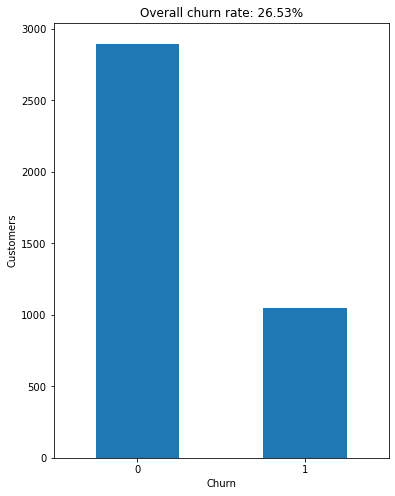

In [15]:
#Try to put this in a function
df = train.churn_Yes.value_counts()
plt.figure(figsize=(6,8))
df.plot.bar(rot = 0)
plt.title(f"Overall churn rate: {churn_rate:.2%}")
plt.xlabel('Churn')
plt.ylabel('Customers')
plt.show()

In [16]:
def churn_bar(df):
    df = df.churn_Yes.value_counts()
    plt.figure(figsize=(6,8))
    df.plot.bar(rot = 0)
    plt.title(f"Overall churn rate: {churn_rate:.2%}")
    plt.xlabel('Churn')
    plt.ylabel('Customers')

    plt.show()

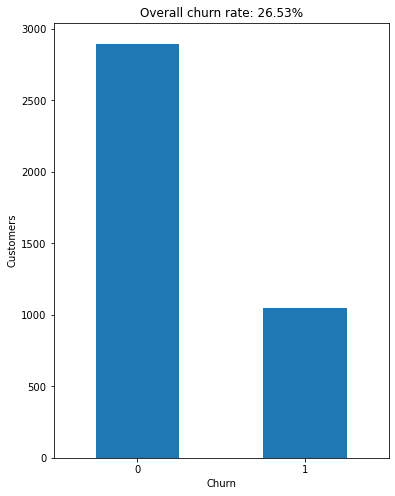

In [17]:
churn_bar(train)

In [18]:
train_corr = train.corr()
train_corr

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,is_male,churn_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,bank_transfer,credit_card,electronic_check,mailed_check,dsl,fiber_optic,no_internet_service
senior_citizen,1.000000,0.022743,-0.206147,0.021272,0.010498,0.141087,-0.027093,0.082438,0.059878,-0.052915,0.108692,0.119603,0.156970,0.220297,0.104086,0.004424,0.137998,0.132122,-0.037158,-0.119107,-0.001889,-0.026293,0.166820,-0.161532,-0.100840,0.248774,-0.184221
partner,0.022743,1.000000,0.450387,0.385079,0.020379,0.144594,0.144401,0.146022,0.160768,0.134771,0.162712,0.126876,-0.016823,0.111287,0.330014,-0.018044,-0.158691,-0.288769,0.096045,0.245930,0.104030,0.091982,-0.077642,-0.107153,0.004772,0.002793,-0.008883
dependents,-0.206147,0.450387,1.000000,0.167668,0.006231,-0.021148,0.084476,0.022737,0.016873,0.076896,-0.018500,-0.054415,-0.120217,-0.116904,0.069458,-0.005959,-0.167771,-0.240337,0.066603,0.217621,0.040283,0.066259,-0.143641,0.057091,0.045176,-0.167971,0.150828
tenure,0.021272,0.385079,0.167668,1.000000,0.008510,0.330764,0.325176,0.366900,0.370069,0.319004,0.291585,0.273170,0.012484,0.253502,0.826644,-0.009337,-0.346061,-0.643937,0.202589,0.559651,0.265575,0.225430,-0.213188,-0.247185,0.009551,0.028064,-0.044935
phone_service,0.010498,0.020379,0.006231,0.008510,1.000000,0.277627,-0.095791,-0.053362,-0.073520,-0.090528,-0.011343,-0.021694,0.009045,0.245734,0.113085,-0.005625,0.009568,-0.003738,0.011903,-0.007160,0.001713,0.000153,-0.001978,0.000385,-0.442900,0.284584,0.167309
multiple_lines,0.141087,0.144594,-0.021148,0.330764,0.277627,1.000000,0.094621,0.216400,0.210375,0.093312,0.270546,0.269533,0.165630,0.495375,0.473081,-0.003872,0.033437,-0.085391,0.008231,0.092297,0.089165,0.056589,0.070936,-0.225945,-0.194973,0.367111,-0.218567
online_security,-0.027093,0.144401,0.084476,0.325176,-0.095791,0.094621,1.000000,0.287033,0.271512,0.363981,0.194414,0.202366,0.001428,0.309024,0.416498,-0.019359,-0.158750,-0.242169,0.082596,0.204253,0.097922,0.109482,-0.118885,-0.071600,0.303877,-0.012425,-0.335717
online_backup,0.082438,0.146022,0.022737,0.366900,-0.053362,0.216400,0.287033,1.000000,0.316008,0.308126,0.291211,0.276050,0.133107,0.449610,0.516631,-0.007996,-0.088072,-0.162230,0.071364,0.121271,0.081550,0.076465,-0.003172,-0.153901,0.155214,0.171974,-0.386953
device_protection,0.059878,0.160768,0.016873,0.370069,-0.073520,0.210375,0.271512,0.316008,1.000000,0.328666,0.396003,0.406669,0.103812,0.489726,0.531339,0.000400,-0.068312,-0.229601,0.111009,0.161922,0.091354,0.104260,-0.000216,-0.194706,0.145559,0.182976,-0.389104
tech_support,-0.052915,0.134771,0.076896,0.319004,-0.090528,0.093312,0.363981,0.308126,0.328666,1.000000,0.281036,0.274015,0.045509,0.336950,0.423984,-0.012149,-0.150712,-0.294222,0.098030,0.250408,0.106405,0.089713,-0.109661,-0.070878,0.319316,-0.025976,-0.337162


In [19]:
#calculate the correlation of all columns in the train dataset.
train_corr = train.corr()
cols = train_corr['churn_Yes'].sort_values(ascending=False)

In [20]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,3943.0,0.162820,0.369248,0.00,0.000,0.00,0.00,1.00
partner,3943.0,0.486685,0.499886,0.00,0.000,0.00,1.00,1.00
dependents,3943.0,0.307634,0.461573,0.00,0.000,0.00,1.00,1.00
tenure,3943.0,32.473244,24.551176,0.00,9.000,29.00,55.00,72.00
phone_service,3943.0,0.907431,0.289864,0.00,1.000,1.00,1.00,1.00
multiple_lines,3943.0,0.430383,0.495193,0.00,0.000,0.00,1.00,1.00
online_security,3943.0,0.291149,0.454350,0.00,0.000,0.00,1.00,1.00
online_backup,3943.0,0.353031,0.477973,0.00,0.000,0.00,1.00,1.00
device_protection,3943.0,0.355567,0.478745,0.00,0.000,0.00,1.00,1.00
tech_support,3943.0,0.292924,0.455162,0.00,0.000,0.00,1.00,1.00


<AxesSubplot:>

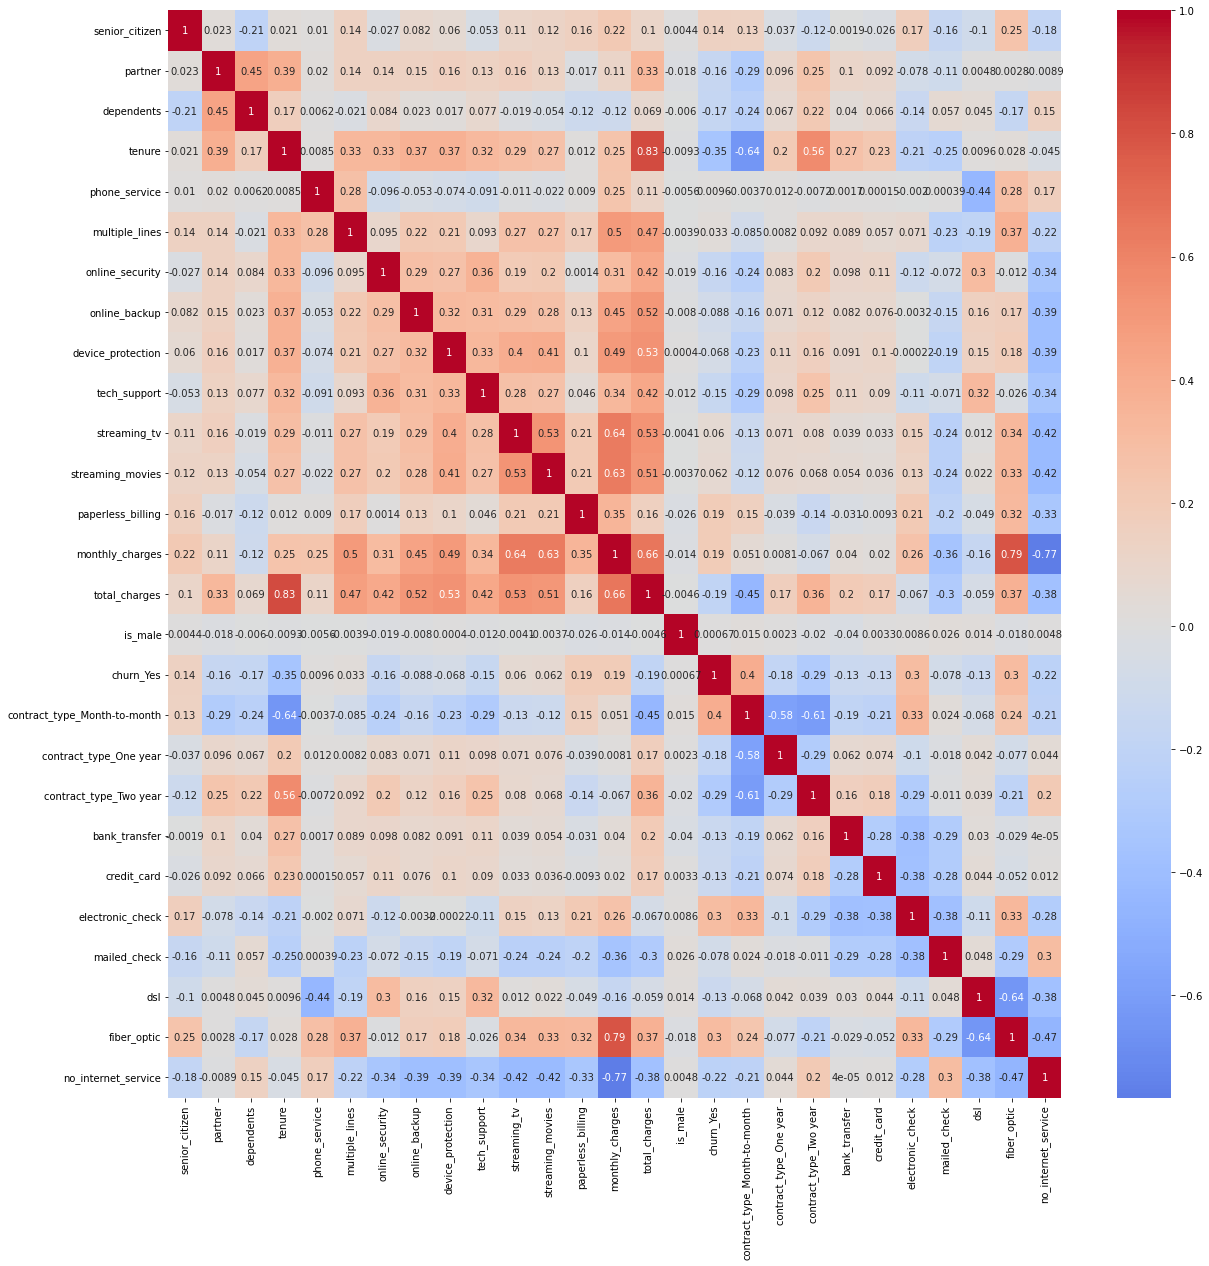

In [21]:
#Try to narrow down more
plt.figure(figsize=(20,20))
sns.heatmap(train.corr() , cmap='coolwarm', center=0, annot=True)

In [22]:
#Checking the columns that has correlation more than -.22
list(cols[cols < (-.18)].index)

['contract_type_One year',
 'total_charges',
 'no_internet_service',
 'contract_type_Two year',
 'tenure']

In [23]:
#Same thing as above
list(cols[cols > (.13)].index)

['churn_Yes',
 'contract_type_Month-to-month',
 'fiber_optic',
 'electronic_check',
 'monthly_charges',
 'paperless_billing',
 'senior_citizen']

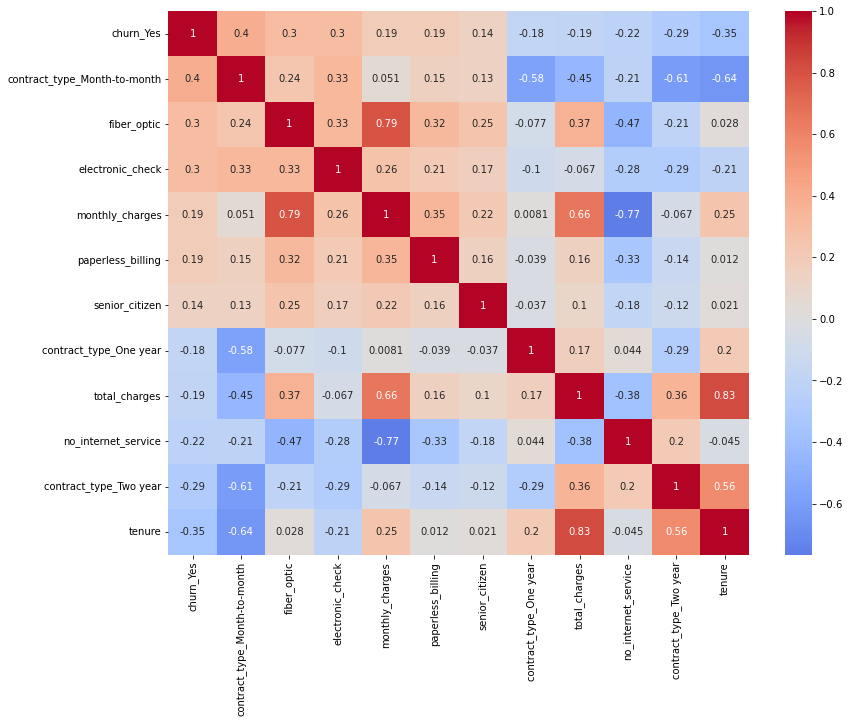

In [24]:
#Little better but still a busy heatmap
#Heatmap is usefull for analysis like this but do not include in a final notebook 
#The end_user might or might not understand the purpose of heatmap like below
col_listf = list(cols[cols > (.13)].index) + list(cols[cols < (-.18)].index)
col_listf

plt.figure(figsize=(13,10))
sns.heatmap(train[col_listf].corr() , cmap='coolwarm', center=0, annot=True)

plt.title('')
plt.show()

Takeaways

churn has positive correlation:

- internet type : fiber_optic
- payment type: electronic check

churn has negative correlation:
- two year
- tenure
- online_security

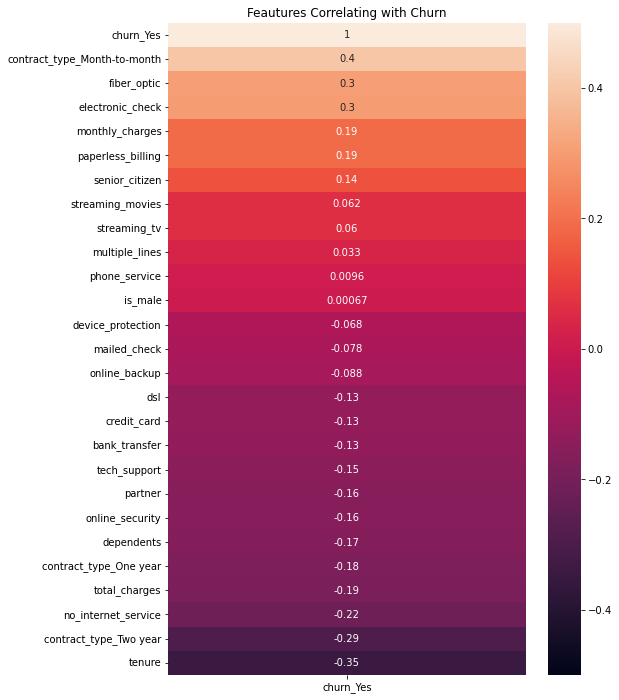

In [25]:
plt.figure(figsize=(8,12))
churn_heatmap = sns.heatmap(train.corr()[['churn_Yes']].sort_values(by='churn_Yes', ascending=False), vmin=-.5, vmax=.5, annot=True)
churn_heatmap.set_title('Feautures Correlating with Churn')
plt.show()

In [26]:
def get_churn_heatmap(df):
    plt.figure(figsize=(8,12))
    churn_heatmap = sns.heatmap(df.corr()[['churn_Yes']].sort_values(by='churn_Yes', ascending=False), vmin=-.5, vmax=.5, annot=True)
    churn_heatmap.set_title('Feautures Correlating with Churn')
    
    return churn_heatmap

<AxesSubplot:title={'center':'Feautures Correlating with Churn'}>

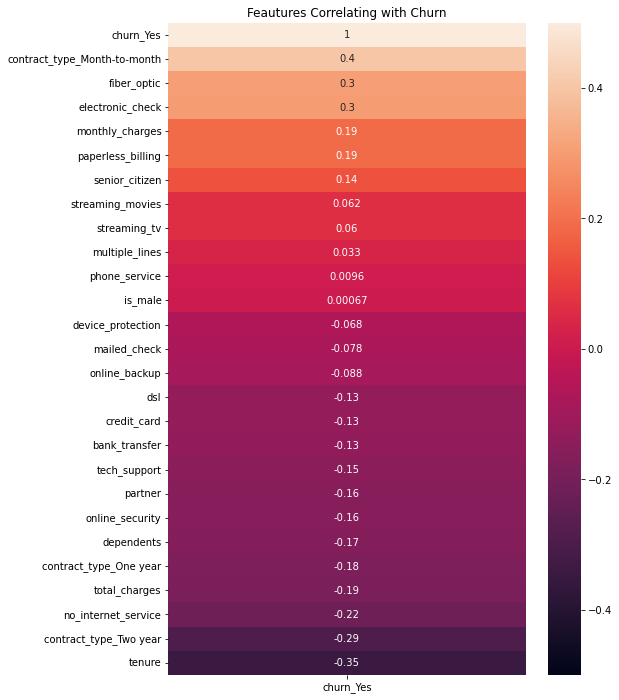

In [27]:
get_churn_heatmap(train)

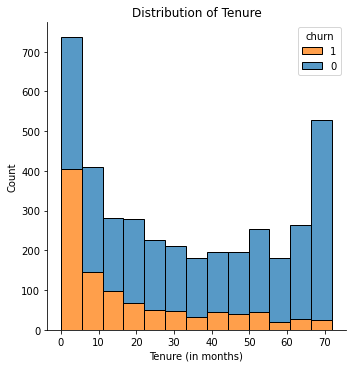

In [97]:
# Distribution of Tenure
sns.displot(train,
             x=train.tenure,
             hue='churn_Yes',
             multiple='stack',
             legend=False
             )

plt.title("Distribution of Tenure")
plt.xlabel('Tenure (in months)')
plt.legend(title = 'churn', loc='best',labels=[1,0])

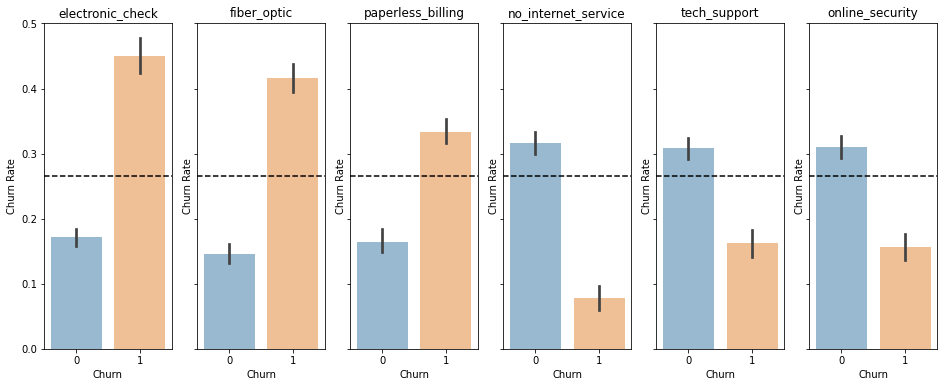

In [93]:
#enumerate() allows us to iterate through a sequence but it keeps track of both the index and the element
#Base on the correlation above we want to see which has high churn rate
features = ['electronic_check','fiber_optic','paperless_billing','no_internet_service','tech_support','online_security']


_, ax = plt.subplots(nrows=1, ncols=len(features), figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature,'churn_Yes', data=train, ax=ax[i], alpha=0.5)
    ax[i].set_xlabel('Churn')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

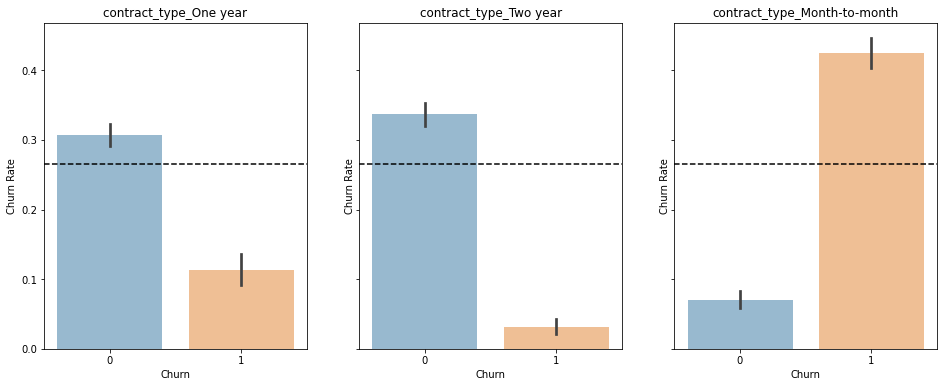

In [54]:
#Same as above
features = ['contract_type_One year','contract_type_Two year','contract_type_Month-to-month']


_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature,'churn_Yes', data=train, ax=ax[i], alpha=0.5)
    ax[i].set_xlabel('Churn')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

Take Away:
   - We can see a high churned rate on electronic check, paperless_billing, month to month and fiber_optic
   - And customer who has phone service that is one line, has about the same churned rate as the customer didnt churned
   - Customer that has internet service as fiber optic have higher churn rate, why? and then same with electronic check, so we need to check the correlation

In [29]:
#The first month has really high churn rate
#Our driver will be tenure

In [30]:
#We will use train datset from this point and on
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5310 to 6817
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   3943 non-null   object 
 1   senior_citizen                3943 non-null   int64  
 2   partner                       3943 non-null   int64  
 3   dependents                    3943 non-null   int64  
 4   tenure                        3943 non-null   int64  
 5   phone_service                 3943 non-null   int64  
 6   multiple_lines                3943 non-null   int64  
 7   online_security               3943 non-null   int64  
 8   online_backup                 3943 non-null   int64  
 9   device_protection             3943 non-null   int64  
 10  tech_support                  3943 non-null   int64  
 11  streaming_tv                  3943 non-null   int64  
 12  streaming_movies              3943 non-null   int64  
 13  

In [59]:
#First we need to get the columns that needed base on the graph above
cols = ['dsl','fiber_optic','multiple_lines','phone_service',
        'bank_transfer','paperless_billing','electronic_check','mailed_check','credit_card','no_internet_service',
        'contract_type_Month-to-month','contract_type_One year','contract_type_Two year',
        'tenure','churn_Yes','total_charges','monthly_charges']

In [91]:
#Calculate the overall churn rate
churn_rate = train['churn_Yes'].mean()

In [60]:
#We set tenure at 12 because 
#we want a dataframe with the first month of tenure specified
tenure = 2
df_month1 = train[cols][train['tenure'] < tenure ]

In [61]:
#We want to know the total customers in the specified month first
total_customer = train.tenure[train['tenure'] < tenure].count()
total_customer

341

In [62]:
#Want to know how many customer in that first month
total_customer_month1 = train.tenure[train['tenure']== 1].count()
total_customer_month1

333

In [63]:
#We create a dataframe for churned customers in that specified months
cust_churned = df_month1.churn_Yes[df_month1['churn_Yes']== 1].count()#571 churned customer in that specified months
churned_df = df_month1[(df_month1['churn_Yes']==1)]
cust_churned

212

In [64]:
print(f"churn rate in the first month of Tenure: {(cust_churned/total_customer):.2%}")

churn rate in the first month of Tenure: 62.17%


In [76]:
#We create a datframe that all the column has high churn rate
cols_1v = ['monthly_charges','electronic_check','paperless_billing',
           'fiber_optic',
           'contract_type_Month-to-month','contract_type_One year','contract_type_Two year','churn_Yes']
res_df= pd.DataFrame((churned_df[cols_1v].sum()),columns=['churn_counts'])

In [77]:
ec=(res_df.loc['electronic_check'][0]).astype(int)
ppl=(res_df.loc['paperless_billing'][0]).astype(int)
fo=(res_df.loc['fiber_optic'][0]).astype(int)

In [92]:
print("")
print(f'** FIRST {tenure - 1} MONTHS OF TENURE AND CHURN** ')
print("")
print(f"Total customer in the first month: {total_customer}")
print(f"Total customer cancellations in the first month: {cust_churned}")
print("")
print(f"Churn rate in the first month of Tenure: {(cust_churned/total_customer):.2%}")
print(f"Paperless_billing:                       {(ppl/cust_churned):.2%}")
print(f'Electronic_check payment type :          {(ec/cust_churned):.2%} ')
print(f"Fiber_optic:                             {(fo/cust_churned):.2%}")
print("")
print(f'Overall Churn Rate: {churn_rate:.2%}')


** FIRST 1 MONTHS OF TENURE AND CHURN** 

Total customer in the first month: 341
Total customer cancellations in the first month: 212

Churn rate in the first month of Tenure: 62.17%
Paperless_billing:                       66.51%
Electronic_check payment type :          57.08% 
Fiber_optic:                             53.30%

Overall Churn Rate: 26.53%


# Stats

$H_o$: There is no difference between churn and tenure

$H_a$: There is a difference between churn and tenure

So this will be a t-test

In [35]:
#We set significant level at 5%
α = 0.5
t, p = stats.ttest_1samp(train.tenure, train.churn_Yes.mean())

In [36]:
t,p

(82.37669227970096, 0.0)

In [37]:
if (p < α):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis




H$o$: Rate of churn is not dependent on Fiber Optic .

H$a$: Rate of churn is dependent on Fiber Optic status.


In [38]:
observed = pd.crosstab(train.fiber_optic, train.churn_Yes)
observed

churn_Yes,0,1
fiber_optic,,
0,1878,320
1,1019,726


In [39]:
chi2, p, degf, expected =stats.chi2_contingency(observed)

In [40]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1878  320]
 [1019  726]]
---
Expected

[[1614  583]
 [1282  462]]
---

chi^2 = 363.6806
p     = 0.0000


In [41]:
if p < α:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis



H$o$: Rate of churn is not dependent on using auto_pay as the form of payment.

H$a$: Rate of churn is dependent on using auto_pay as the form of payment.


In [42]:
observed2 = pd.crosstab(train.paperless_billing_Yes, train.churn_Yes)
observed2

churn_Yes,0,1
paperless_billing_Yes,,
0,1335,263
1,1562,783


In [43]:
chi2, p, degf, expected =stats.chi2_contingency(observed2)

In [44]:
print('Observed\n')
print(observed2.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1335  263]
 [1562  783]]
---
Expected

[[1174  423]
 [1722  622]]
---

chi^2 = 138.9267
p     = 0.0000


In [50]:
if p < α:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis


In [105]:
#Modeling

In [107]:
#Look for which value occur the most in churn
#and then set it as a baseline accuracy
train.churn.value_counts().idxmax()

0

In [73]:
train['baseline']= train.churn_Yes.value_counts().idxmax()

In [74]:
#Set the baseline
baseline_acc =(train.baseline == train.churn_Yes).mean()
baseline_acc

0.7347197565305605

In [75]:
print(f'The baseline accuracy for No Churn in all cases on the telco Dataset is {(train.baseline == train.churn_Yes).mean():.3%}')

The baseline accuracy for No Churn in all cases on the telco Dataset is 73.472%


In [98]:
x_col = ['fiber_optic', 'electronic_check', 'monthly_charges', 'tenure','contract_type_Month-to-month', 'contract_type_One year','contract_type_Two year']
y_col = 'churn_Yes'

In [99]:
X_train =  train[x_col]
y_train = train[y_col]
X_validate, y_validate = validate[x_col], validate[y_col]
X_test, y_test = test[x_col], test[y_col]

I am trying to predict the customers that will churn so the positive variable will be churn = 1 in my folowing models.`

Possible Outcomes:

TP: Predict customers churn and customers did churn

TN: Predict no customers churn and customers did not churn

FP: Predict customers churn but customer did not churn

FN: Predict no customers churn but customers did churn

### Decision Tree

In [100]:
#Create the thing
model_dtl= DecisionTreeClassifier(max_depth=5, max_leaf_nodes = 6)

In [101]:
# fit the model
model_dtl.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=6)

In [102]:
# look at the model scores for training set and validate set
print(f'training score: {model_dtl.score(X_train, y_train):.2%}')
print(f'validate score: {model_dtl.score(X_validate, y_validate):.2%}')

training score: 78.85%
validate score: 79.07%


In [103]:
y_pred = model_dtl.predict(X_train)

In [104]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2897
           1       0.68      0.38      0.49      1046

    accuracy                           0.79      3943
   macro avg       0.75      0.66      0.68      3943
weighted avg       0.77      0.79      0.77      3943



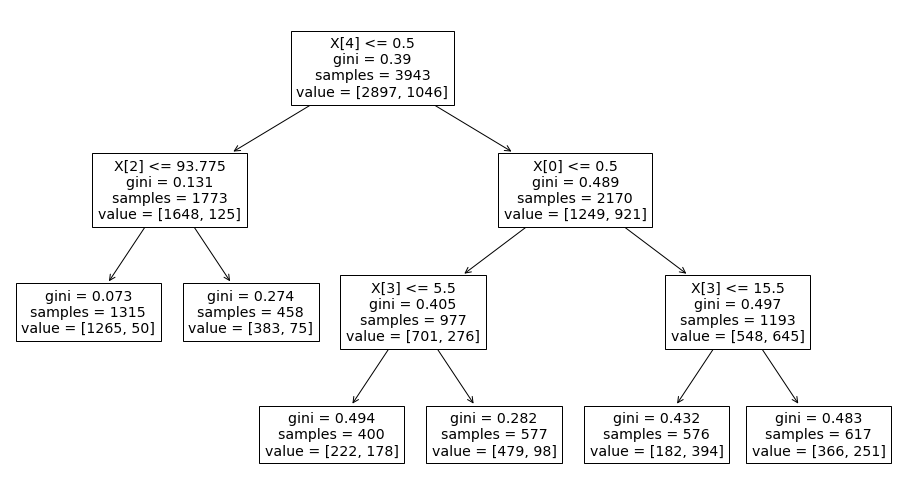

In [105]:
#Just plot the tree just to see 
#Not going to plot for other model since it just serves as an example
plt.figure(figsize=(16,9))
plot_tree(model_dtl)
plt.show()

In [106]:
#Model 2
#Same steps as above but we add some hyperparameter 
model_dt2 = DecisionTreeClassifier(max_depth=5 , max_features = 4, random_state=123)
# fit the model
model_dt2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_features=4, random_state=123)

In [107]:
# look at the model scores for training set and validate set
print(f'training score: {model_dt2.score(X_train, y_train):.2%}')
print(f'validate score: {model_dt2.score(X_validate, y_validate):.2%}')

training score: 79.58%
validate score: 79.07%


In [108]:
y_pred = model_dt2.predict(X_train)

In [109]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      2897
           1       0.64      0.53      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.71      0.72      3943
weighted avg       0.79      0.80      0.79      3943



In [110]:
#Model 3
#Same steps as above but we add some hyperparameter 
model_dt3 = DecisionTreeClassifier(max_depth=2 , min_samples_split = 3, max_leaf_nodes = 4, random_state=123)
# fit the model
model_dt3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, min_samples_split=3,
                       random_state=123)

In [111]:
# look at the model scores for training set and validate set
print(f'training score: {model_dt3.score(X_train, y_train):.2%}')
print(f'validate score: {model_dt3.score(X_validate, y_validate):.2%}')

training score: 75.93%
validate score: 76.70%


In [112]:
y_pred = model_dt3.predict(X_train)

In [113]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      2897
           1       0.54      0.62      0.58      1046

    accuracy                           0.76      3943
   macro avg       0.70      0.71      0.70      3943
weighted avg       0.77      0.76      0.76      3943



In [114]:
#Model 4
model_dt4 = DecisionTreeClassifier(max_depth=10, max_leaf_nodes= 6, class_weight= None, random_state=123)
# fit the model
model_dt4.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=6, random_state=123)

In [115]:
# look at the model scores for training set and validate set
print(f'training score: {model_dt4.score(X_train, y_train):.2%}')
print(f'validate score: {model_dt4.score(X_validate, y_validate):.2%}')

training score: 78.85%
validate score: 79.07%


In [116]:
y_pred = model_dt4.predict(X_train)

In [117]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2897
           1       0.68      0.38      0.49      1046

    accuracy                           0.79      3943
   macro avg       0.75      0.66      0.68      3943
weighted avg       0.77      0.79      0.77      3943



In [118]:
#Model 5
model_dt5 = DecisionTreeClassifier(max_depth=4, random_state=123)
# fit the model
model_dt5.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=123)

In [119]:
# look at the model scores for training set and validate set
print(f'training score: {model_dt5.score(X_train, y_train):.2%}')
print(f'validate score: {model_dt5.score(X_validate, y_validate):.2%}')

training score: 79.15%
validate score: 79.66%


In [120]:
y_pred = model_dt5.predict(X_train)

In [121]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2897
           1       0.63      0.51      0.56      1046

    accuracy                           0.79      3943
   macro avg       0.73      0.70      0.71      3943
weighted avg       0.78      0.79      0.78      3943



In [122]:
#Model 2 is the best in this case

## KNN

In [123]:
#getting the best model
#using a loop to put in a value for n-neighbors value from 1 to 17
for k in range(0, 17):
    k += 1
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    acc_train = knn.score(X_train, y_train)
    acc_vali = knn.score(X_validate, y_validate )
    
    y_pred = knn.predict(X_train)
    y_pred_proba = knn.predict_proba(X_train)
    
    print('__________________________________________________________')
    print(f'Model: {k} when k is {k}')
    print(f'training score: {knn.score(X_train, y_train):.2%}')
    print(f'validate score: {knn.score(X_validate, y_validate):.2%}')
    print ('------------------------------------------')
    print(classification_report(y_train, y_pred))
    

__________________________________________________________
Model: 1 when k is 1
training score: 99.04%
validate score: 73.21%
------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2897
           1       0.99      0.97      0.98      1046

    accuracy                           0.99      3943
   macro avg       0.99      0.98      0.99      3943
weighted avg       0.99      0.99      0.99      3943

__________________________________________________________
Model: 2 when k is 2
training score: 86.23%
validate score: 76.52%
------------------------------------------
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2897
           1       1.00      0.48      0.65      1046

    accuracy                           0.86      3943
   macro avg       0.92      0.74      0.78      3943
weighted avg       0.88      0.86      0.84      3943

________

In [ ]:
#Model 1 is peform the best

## Logistic Regression

In [124]:
logit1 =LogisticRegression(C=1.0 , random_state=123)
logit1.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [125]:
y_pred = logit1.predict(X_train)
print(f'training score: {logit1.score(X_train, y_train):.2%}')
print(f'validate score: {logit1.score(X_validate, y_validate):.2%}')

training score: 79.08%
validate score: 78.24%


In [126]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2897
           1       0.64      0.49      0.55      1046

    accuracy                           0.79      3943
   macro avg       0.73      0.69      0.71      3943
weighted avg       0.78      0.79      0.78      3943



In [127]:
logit2 = LogisticRegression(C= 100, multi_class = 'auto', random_state =123)
logit2.fit(X_train, y_train)
y_pred = logit2.predict(X_train)
print(f'training score: {logit2.score(X_train, y_train):.2%}')
print(f'validate score: {logit2.score(X_validate, y_validate):.2%}')

training score: 79.10%
validate score: 78.24%


In [128]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2897
           1       0.64      0.49      0.55      1046

    accuracy                           0.79      3943
   macro avg       0.73      0.69      0.71      3943
weighted avg       0.78      0.79      0.78      3943



In [129]:
logit3 = LogisticRegression(C= .5, dual= False, solver= 'lbfgs', random_state =1349)
logit3.fit(X_train, y_train)
y_pred = logit3.predict(X_train)
print(f'training score: {logit3.score(X_train, y_train):.2%}')
print(f'validate score: {logit3.score(X_validate, y_validate):.2%}')

training score: 79.05%
validate score: 78.42%


In [130]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2897
           1       0.64      0.48      0.55      1046

    accuracy                           0.79      3943
   macro avg       0.73      0.69      0.71      3943
weighted avg       0.78      0.79      0.78      3943



In [131]:
logit4 = LogisticRegression(C = .2,random_state =1349, class_weight = 'balanced')
logit4.fit(X_train, y_train)
y_pred = logit4.predict(X_train)
print(f'training score: {logit4.score(X_train, y_train):.2%}')
print(f'validate score: {logit4.score(X_validate, y_validate):.2%}')

training score: 73.85%
validate score: 75.58%


In [132]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      2897
           1       0.50      0.78      0.61      1046

    accuracy                           0.74      3943
   macro avg       0.70      0.75      0.71      3943
weighted avg       0.80      0.74      0.75      3943



In [133]:
#Test Set

In [134]:
y_pred = logit3.predict(X_test)

In [135]:
print(f'training score: {logit3.score(X_train, y_train):.2%}')
print(f'validate score: {logit3.score(X_validate, y_validate):.2%}')
print(f'test score: {logit3.score(X_test, y_test):.2%}')

training score: 79.05%
validate score: 78.42%
test score: 81.19%


In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1035
           1       0.69      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



We can see our test dataset has 81% accuracy better than train and validate but a lot better than baseline accuracy which is 73%

In [137]:
#Creating a prediction csv 

In [138]:
#Get the prediction probability from model 3 in logistic regression since that is the mvp
#Put it a dataframe 
#Concat it with customer_id in test dataset 

In [150]:
proba_test = logit3.predict_proba(X_test)

In [140]:
prob_df = pd.DataFrame(proba_test, columns =['no_churn', 'churn_prob'])
prob_df.head()

,no_churn,churn_prob
0,0.865741,0.134259
1,0.981487,0.018513
2,0.348682,0.651318
3,0.369192,0.630808
4,0.274113,0.725887


In [141]:
prob_df.drop(columns= 'no_churn',inplace =True)

In [142]:
pred = logit3.predict(X_test)

In [143]:
test.head()

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,is_male,churn_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,bank_transfer,credit_card,electronic_check,mailed_check,dsl,fiber_optic,no_internet_service
3160,4531-AUZNK,0,1,1,51,1,1,1,0,0,1,1,0,1,95.15,5000.05,0,0,0,1,0,0,0,0,1,0,1,0
1577,2296-DKZFP,0,1,0,65,1,0,1,1,1,0,0,1,0,71.00,4386.20,0,0,0,0,1,1,0,0,0,1,0,0
6823,9692-TUSXH,0,0,0,18,1,0,1,0,0,0,1,1,1,96.05,1740.70,0,1,1,0,0,0,0,1,0,0,1,0
3615,5129-JLPIS,0,0,0,25,1,0,1,0,1,1,1,1,1,105.50,2686.05,1,0,1,0,0,0,0,1,0,0,1,0
882,1273-MTETI,1,0,0,4,1,1,0,0,1,0,0,1,1,88.85,372.45,0,1,1,0,0,0,0,1,0,0,1,0


In [144]:
reset_test = test['customer_id'].reset_index()
reset_test.head()

,index,customer_id
0,3160,4531-AUZNK
1,1577,2296-DKZFP
2,6823,9692-TUSXH
3,3615,5129-JLPIS
4,882,1273-MTETI


In [145]:
reset_test.drop(columns='index', inplace=True)

In [146]:
test_proba_df = pd.concat([reset_test, prob_df], axis=1)
test_proba_df.head()

,customer_id,churn_prob
0,4531-AUZNK,0.134259
1,2296-DKZFP,0.018513
2,9692-TUSXH,0.651318
3,5129-JLPIS,0.630808
4,1273-MTETI,0.725887


In [147]:
test_proba_df['churn_predicted'] = pred

In [148]:
test_proba_df.sample(5)

,customer_id,churn_prob,churn_predicted
1402,9361-YNQWJ,0.018693,0
1336,3254-YRILK,0.617244,1
1310,8414-MYSHR,0.726835,1
1123,8270-RKSAP,0.632731,1
38,7611-YKYTC,0.423491,0


In [ ]:
#This will export as a csv file
#Uncomment it to make it works

#test_proba_df.to_csv('telco_predictions.csv')